In [1]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers scikit-learn matplotlib seaborn pandas numpy

from google.colab import drive
drive.mount('/content/drive')

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import os

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f"Setup complete - GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Setting up...
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setup complete - GPU: CPU


In [2]:
# LOAD DATASET

print("Loading dataset...")

df = pd.read_csv('data/complete_dataset.csv')

print(f"Total samples: {len(df)}")
print(f"Human: {len(df[df['label']=='human'])}")
print(f"AI: {len(df[df['label']=='ai'])}")

df['label_numeric'] = (df['label'] == 'ai').astype(int)

print("\nSample preview:")
print(df[['text', 'label', 'word_count']].head())

Loading dataset...
Total samples: 1052
Human: 457
AI: 595

Sample preview:
                                                text  label  word_count
0  The paper considers the problem of modeling a ...  human         129
1  The study shows that the risk of breast cancer...     ai          50
2  I kept it brief, thinking of all those who sti...  human          77
3  Evidence suggests that the lack of strong evid...     ai          86
4  The study shows that if you have a lot of ener...     ai          98


In [3]:
# CALCULATE PERPLEXITY FOR ALL SAMPLES

print("Calculating perplexity for all samples...")

def calculate_perplexity(text, model, tokenizer, device):
    encodings = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512
    )

    input_ids = encodings.input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    perplexity = torch.exp(loss)
    return perplexity.item()

perplexities = []

for idx, row in df.iterrows():
    ppl = calculate_perplexity(row['text'], model, tokenizer, device)
    perplexities.append(ppl)

    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{len(df)}")

df['perplexity'] = perplexities

print(f"\n Calculated perplexity for all {len(df)} samples")
print(f"\nPerplexity statistics:")
print(f"  Mean: {df['perplexity'].mean():.2f}")
print(f"  Std: {df['perplexity'].std():.2f}")
print(f"  Min: {df['perplexity'].min():.2f}")
print(f"  Max: {df['perplexity'].max():.2f}")

df.to_csv('data/dataset_with_perplexity.csv', index=False)
print("\n Saved dataset with perplexity")

Calculating perplexity for all samples...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  Processed 100/1052
  Processed 200/1052
  Processed 300/1052
  Processed 400/1052
  Processed 500/1052
  Processed 600/1052
  Processed 700/1052
  Processed 800/1052
  Processed 900/1052
  Processed 1000/1052

 Calculated perplexity for all 1052 samples

Perplexity statistics:
  Mean: 34.02
  Std: 49.39
  Min: 3.23
  Max: 1063.28

 Saved dataset with perplexity


In [4]:
# EXPLORATORY DATA ANALYSIS

print("Analyzing perplexity distributions...\n")

human_ppl = df[df['label']=='human']['perplexity']
ai_ppl = df[df['label']=='ai']['perplexity']

print("Human text:")
print(f"  Mean: {human_ppl.mean():.2f} ± {human_ppl.std():.2f}")
print(f"  Range: [{human_ppl.min():.2f}, {human_ppl.max():.2f}]")

print("\nAI text:")
print(f"  Mean: {ai_ppl.mean():.2f} ± {ai_ppl.std():.2f}")
print(f"  Range: [{ai_ppl.min():.2f}, {ai_ppl.max():.2f}]")

print(f"\nSeparation:")
print(f"  Difference: {human_ppl.mean() - ai_ppl.mean():.2f}")
print(f"  Ratio: {human_ppl.mean() / ai_ppl.mean():.2f}x")

overlap = ai_ppl.max() > human_ppl.min() and human_ppl.max() > ai_ppl.min()
if overlap:
    overlap_start = max(ai_ppl.min(), human_ppl.min())
    overlap_end = min(ai_ppl.max(), human_ppl.max())
    print(f"\n  Overlap detected: [{overlap_start:.2f}, {overlap_end:.2f}]")
else:
    print(f"\n No overlap - perfect separation possible")

Analyzing perplexity distributions...

Human text:
  Mean: 50.85 ± 69.79
  Range: [11.09, 1063.28]

AI text:
  Mean: 21.09 ± 13.85
  Range: [3.23, 73.66]

Separation:
  Difference: 29.76
  Ratio: 2.41x

  Overlap detected: [11.09, 73.66]


/tmp/ipython-input-2238107034.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax2.boxplot(data_to_plot, labels=['AI', 'Human'], patch_artist=True)


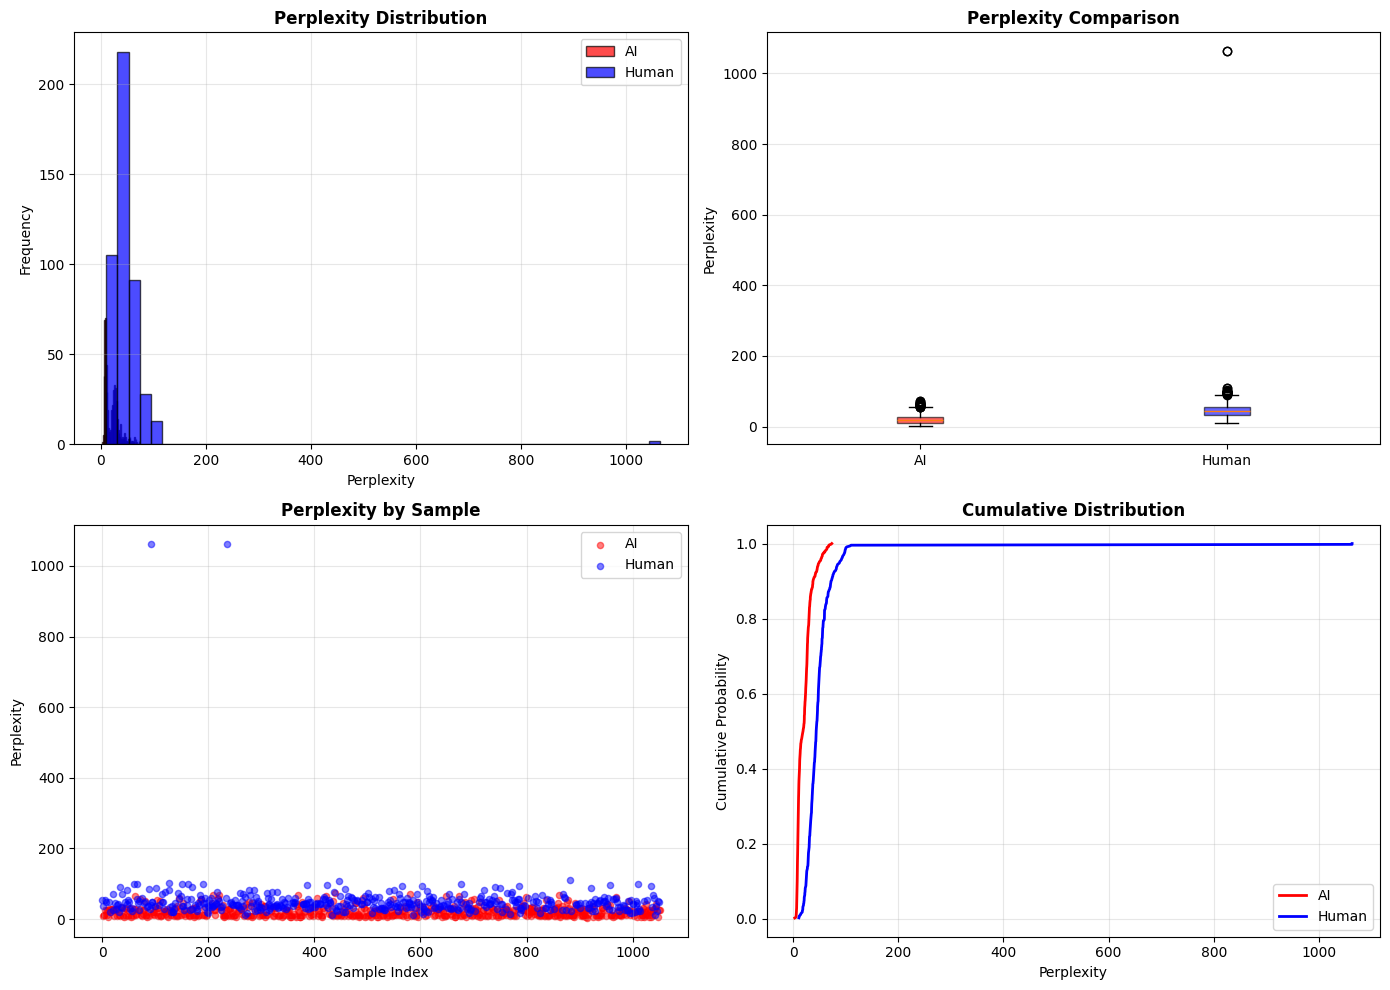

 Visualization saved


In [5]:
# VISUALIZE PERPLEXITY DISTRIBUTIONS

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram
ax1 = axes[0, 0]
ax1.hist(ai_ppl, bins=50, alpha=0.7, label='AI', color='red', edgecolor='black')
ax1.hist(human_ppl, bins=50, alpha=0.7, label='Human', color='blue', edgecolor='black')
ax1.set_xlabel('Perplexity')
ax1.set_ylabel('Frequency')
ax1.set_title('Perplexity Distribution', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Box plot
ax2 = axes[0, 1]
data_to_plot = [ai_ppl, human_ppl]
box = ax2.boxplot(data_to_plot, labels=['AI', 'Human'], patch_artist=True)
box['boxes'][0].set_facecolor('red')
box['boxes'][0].set_alpha(0.6)
box['boxes'][1].set_facecolor('blue')
box['boxes'][1].set_alpha(0.6)
ax2.set_ylabel('Perplexity')
ax2.set_title('Perplexity Comparison', fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Scatter plot
ax3 = axes[1, 0]
ai_indices = df[df['label']=='ai'].index
human_indices = df[df['label']=='human'].index
ax3.scatter(ai_indices, df.loc[ai_indices, 'perplexity'],
           c='red', alpha=0.5, s=20, label='AI')
ax3.scatter(human_indices, df.loc[human_indices, 'perplexity'],
           c='blue', alpha=0.5, s=20, label='Human')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Perplexity')
ax3.set_title('Perplexity by Sample', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: CDF
ax4 = axes[1, 1]
ai_sorted = np.sort(ai_ppl)
human_sorted = np.sort(human_ppl)
ai_cdf = np.arange(1, len(ai_sorted)+1) / len(ai_sorted)
human_cdf = np.arange(1, len(human_sorted)+1) / len(human_sorted)
ax4.plot(ai_sorted, ai_cdf, label='AI', color='red', linewidth=2)
ax4.plot(human_sorted, human_cdf, label='Human', color='blue', linewidth=2)
ax4.set_xlabel('Perplexity')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('Cumulative Distribution', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/perplexity_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved")

In [6]:
# TRAIN/TEST SPLIT

print("Splitting data into train/test sets...")

X = df['perplexity'].values.reshape(-1, 1)
y = df['label_numeric'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"  AI: {y_train.sum()}")
print(f"  Human: {len(y_train) - y_train.sum()}")

print(f"\nTest set: {len(X_test)} samples")
print(f"  AI: {y_test.sum()}")
print(f"  Human: {len(y_test) - y_test.sum()}")

Splitting data into train/test sets...

Train set: 841 samples
  AI: 476
  Human: 365

Test set: 211 samples
  AI: 119
  Human: 92


In [7]:
# FIND OPTIMAL THRESHOLD

print("Finding optimal threshold on training data...\n")

train_ai_ppl = X_train[y_train == 1].flatten()
train_human_ppl = X_train[y_train == 0].flatten()

threshold_simple = (train_ai_ppl.mean() + train_human_ppl.mean()) / 2

print("Method 1: Simple midpoint")
print(f"  Threshold: {threshold_simple:.2f}")

thresholds = np.linspace(X_train.min(), X_train.max(), 1000)
best_threshold = threshold_simple
best_f1 = 0

for threshold in thresholds:
    y_pred = (X_train.flatten() < threshold).astype(int)
    f1 = f1_score(y_train, y_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nMethod 2: Maximize F1 score")
print(f"  Threshold: {best_threshold:.2f}")
print(f"  F1 score: {best_f1:.3f}")

optimal_threshold = best_threshold
print(f"\n Using optimal threshold: {optimal_threshold:.2f}")
print(f"   Rule: PPL < {optimal_threshold:.2f} → AI")
print(f"         PPL > {optimal_threshold:.2f} → Human")

Finding optimal threshold on training data...

Method 1: Simple midpoint
  Threshold: 36.24

Method 2: Maximize F1 score
  Threshold: 34.00
  F1 score: 0.840

 Using optimal threshold: 34.00
   Rule: PPL < 34.00 → AI
         PPL > 34.00 → Human


In [8]:
# EVALUATE ON TEST SET

print("Evaluating on test set...\n")

y_pred_test = (X_test.flatten() < optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Performance Metrics:")
print(f"  Accuracy:  {accuracy:.1%}")
print(f"  Precision: {precision:.1%}")
print(f"  Recall:    {recall:.1%}")
print(f"  F1 Score:  {f1:.3f}")

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (Human→Human):  {tn}")
print(f"  False Positives (Human→AI):    {fp}")
print(f"  False Negatives (AI→Human):    {fn}")
print(f"  True Positives (AI→AI):        {tp}")

print(f"\nError Analysis:")
print(f"  Missed AI texts: {fn}/{fn+tp} ({fn/(fn+tp):.1%})")
print(f"  False alarms: {fp}/{fp+tn} ({fp/(fp+tn):.1%})")

Evaluating on test set...

Performance Metrics:
  Accuracy:  79.1%
  Precision: 78.6%
  Recall:    86.6%
  F1 Score:  0.824

Confusion Matrix:
  True Negatives (Human→Human):  64
  False Positives (Human→AI):    28
  False Negatives (AI→Human):    16
  True Positives (AI→AI):        103

Error Analysis:
  Missed AI texts: 16/119 (13.4%)
  False alarms: 28/92 (30.4%)


Generating ROC curve...


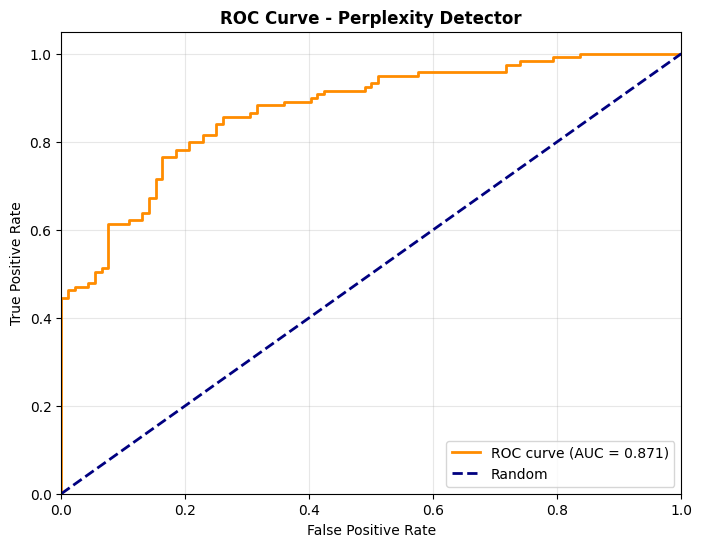

 AUC Score: 0.871


In [9]:
# ROC CURVE

print("Generating ROC curve...")

y_scores = -X_test.flatten()

fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Perplexity Detector', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('results/roc_curve_perplexity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" AUC Score: {roc_auc:.3f}")

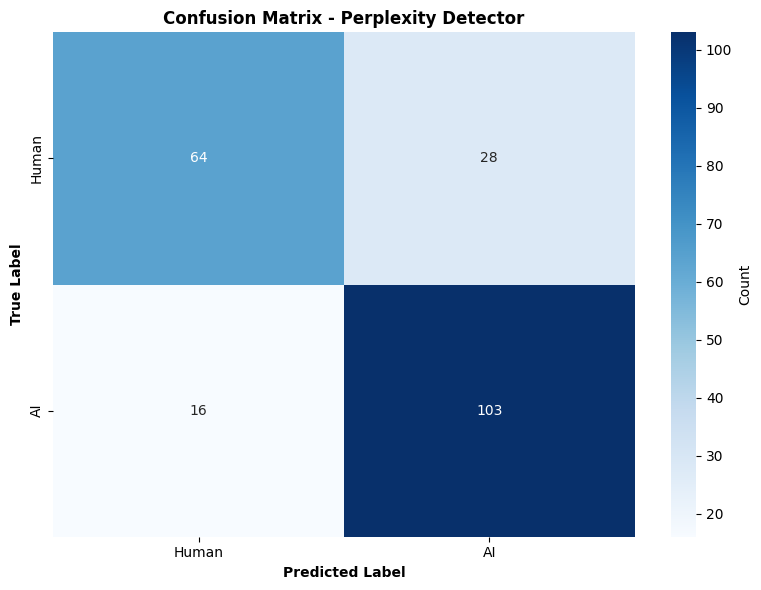

Confusion matrix saved


In [10]:
# CONFUSION MATRIX VISUALIZATION

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title('Confusion Matrix - Perplexity Detector', fontweight='bold')

plt.tight_layout()
plt.savefig('results/confusion_matrix_perplexity.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved")

In [11]:
# ERROR ANALYSIS

print("Analyzing misclassified samples...\n")

test_df = pd.DataFrame({
    'text': df.iloc[X_test.flatten().argsort()]['text'].values,
    'true_label': y_test,
    'pred_label': y_pred_test,
    'perplexity': X_test.flatten()
})

test_df['correct'] = test_df['true_label'] == test_df['pred_label']

false_positives = test_df[(test_df['true_label']==0) & (test_df['pred_label']==1)]
false_negatives = test_df[(test_df['true_label']==1) & (test_df['pred_label']==0)]

print(f"False Positives (Human labeled as AI): {len(false_positives)}")
if len(false_positives) > 0:
    print("\nExample False Positive:")
    fp = false_positives.iloc[0]
    print(f"  Perplexity: {fp['perplexity']:.2f}")
    print(f"  Text: {fp['text'][:150]}...")

print(f"\nFalse Negatives (AI labeled as Human): {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nExample False Negative:")
    fn = false_negatives.iloc[0]
    print(f"  Perplexity: {fn['perplexity']:.2f}")
    print(f"  Text: {fn['text'][:150]}...")

test_df.to_csv('results/test_predictions_perplexity.csv', index=False)
print("\n✅ Test predictions saved")

Analyzing misclassified samples...

False Positives (Human labeled as AI): 28

Example False Positive:
  Perplexity: 26.44
  Text: In July 2022, I joined the Ministry of Social Affairs as secretary of state for the 2030 Agenda. But Podemos was beginning to collapse. Though Iglesia...

False Negatives (AI labeled as Human): 16

Example False Negative:
  Perplexity: 34.53
  Text: Over the past decade,Researchers are increasingly examiningPrevious literature highlightsEmerging evidence points toSeveral studies have reportedCurre...

✅ Test predictions saved


In [12]:
# SAVE RESULTS SUMMARY

results_summary = {
    'method': 'Perplexity-based',
    'threshold': optimal_threshold,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc': roc_auc,
    'total_samples': len(df),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'human_mean_ppl': human_ppl.mean(),
    'ai_mean_ppl': ai_ppl.mean(),
}

import json
with open('results/perplexity_detector_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

with open('results/perplexity_detector_summary.txt', 'w') as f:
    f.write("PERPLEXITY-BASED DETECTOR RESULTS\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Optimal Threshold: {optimal_threshold:.2f}\n")
    f.write(f"Accuracy:  {accuracy:.1%}\n")
    f.write(f"Precision: {precision:.1%}\n")
    f.write(f"Recall:    {recall:.1%}\n")
    f.write(f"F1 Score:  {f1:.3f}\n")
    f.write(f"AUC:       {roc_auc:.3f}\n")
    f.write(f"\nHuman Mean PPL: {human_ppl.mean():.2f}\n")
    f.write(f"AI Mean PPL:    {ai_ppl.mean():.2f}\n")

print("✅ Results saved")
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Accuracy:  {accuracy:.1%}")
print(f"Precision: {precision:.1%}")
print(f"Recall:    {recall:.1%}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC:       {roc_auc:.3f}")
print("=" * 60)

✅ Results saved

SUMMARY
Accuracy:  79.1%
Precision: 78.6%
Recall:    86.6%
F1 Score:  0.824
AUC:       0.871
